# Topic 1: Introduction to LangGraph & State Management

**Learning Objectives:**
- Understand what LangGraph is and why we need it
- Learn core concepts: nodes, edges, state, checkpointers
- Build a simple stateful chatbot with conversation memory
- Compare LangGraph with LangChain chains

**Prerequisites:** RAG with LangChain


---
## Section 1: What is LangGraph?

### The Problem with Chains

You have learned about **LangChain chains** - they're great for fixed pipelines:

```python
# Always follows this path:
chain = retriever | prompt | llm | parser
```

But what if you need:
- **Decisions during execution?** ("Should I retrieve or not?")
- **Loops and cycles?** ("Try again if answer is poor")
- **Multiple tools?** ("Use search OR calculator OR retrieval")
- **Complex control flow?** ("If X then Y, else Z")

**That's where LangGraph comes in!**

### LangGraph = State Machines for Agents

LangGraph lets you build **graphs** where:
- **Nodes** are functions that process state
- **Edges** connect nodes (fixed or conditional)
- **State** flows through the graph
- **Agents make decisions** about which path to take

```
           ┌──────────┐
  START ──▶│  Node 1  │
           └──────────┘
                │
                ▼
           Decision?
           ├─ YES ─▶ Node 2 ──┐
           └─ NO  ─▶ Node 3 ──┤
                               ▼
                              END
```

![LangGraph Application Architecture](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/application.png)


---
## Section 2: Setup

First, let's install the required packages and set up our environment.

In [1]:
# Install required packages (run once)
# !pip install -q langgraph langchain langchain-openai python-dotenv

### Import Libraries

In [2]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
import os

print("✅ All imports successful")

✅ All imports successful


### Set Up OpenAI API Key

Create a `.env` file in your project directory with:
```
OPENAI_API_KEY=your_openai_api_key_here
```

In [3]:
# Load environment variables
load_dotenv()
openai_api_key = os.getenv("gen_api_key")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded successfully")

✅ API key loaded successfully


### Initialize the LLM

We'll use **GPT-4o-mini** - it's fast and cost-effective for learning.

In [4]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


---
## Section 3: Core Concept #1 - State

**State** “The single source of truth for the whole agent execution.”  
**State** is the data that flows through your graph.

### MessagesState

For chatbots, LangGraph provides `MessagesState` - it stores conversation history:

```python
{
    "messages": [
        HumanMessage(content="Hello"),
        AIMessage(content="Hi! How can I help?"),
        HumanMessage(content="What's Python?"),
        # ... more messages
    ]
}
```

This is similar to `ConversationBufferMemory`, but more flexible!

**🤔 Reflection Question:** 
How is this different from ConversationBufferMemory? In chains, memory was managed separately. In LangGraph, it's part of the state that flows through nodes!

---
## Section 4: Core Concept #2 - Nodes

**Nodes** are functions that process state and return updates.

### Node Function Signature

```python
def my_node(state: MessagesState) -> dict:
    # Process state
    # Return updates to state
    return {"messages": [new_message]}
```

### The Assistant Node

Let's create our first node - it sends messages to the LLM and gets a response.

In [5]:
# System prompt that defines assistant behavior
sys_msg = SystemMessage(
    content="You are a friendly assistant that answers user questions. Be helpful and concise."
)

def assistant(state: MessagesState) -> dict:
    """
    The assistant node - processes messages and generates response.
    """
    # Combine system prompt with conversation history
    messages = [sys_msg] + state["messages"]
    
    # Get response from LLM
    response = llm.invoke(messages)
    
    # Return as state update
    return {"messages": [AIMessage(content=response.content)]}

print("✅ Assistant node defined")

✅ Assistant node defined


**💡 Key Point:** The node doesn't modify state directly - it returns updates that LangGraph applies automatically!

## Example of a Retriever Node
You don't need to run it

In [6]:
# def retrieve_docs(state: MessagesState):
#     query = state["messages"][-1].content  # latest HumanMessage
#     docs = retriever.invoke(query)

#     return {
#         "messages": [
#             ToolMessage(
#                 content="\n".join(d.page_content for d in docs),
#                 name="retriever"
#             )
#         ]
#     }

---
## Core Concept 2B - Edges

**Edges** are the connections between nodes that control the flow of your agent.

Think of edges as **roads** between cities (nodes). They determine which node to visit next!

### Two Types of Edges

LangGraph has two types of edges:

1. **Fixed/Static Edges** (Normal Edges)
   - Always go from Node A to Node B
   - No decision-making
   - Used for predictable flows

2. **Conditional Edges**
   - Decide which node to visit next based on state
   - Enable agent decision-making
   - Used for dynamic, intelligent behavior

```
Fixed/Static Edge:
  Node A ────────▶ Node B  (always goes to B)

Conditional Edge:
  Node A ────────▶ Decision?
                    ├─ Condition 1 ──▶ Node B
                    ├─ Condition 2 ──▶ Node C
                    └─ Condition 3 ──▶ Node D
```

---
## Section 5: Core Concept #3 - Building the Graph

Now let's connect everything into a **StateGraph**.

In [7]:
# Create a StateGraph with MessagesState
builder = StateGraph(MessagesState)

# Add the assistant node
builder.add_node("assistant", assistant)

# Define the flow:
# START → assistant → END
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

print("✅ Graph structure defined")

✅ Graph structure defined


### Understanding the Flow

```
START → [assistant node] → END
```

- **START:** Entry point (receives user message)
- **assistant:** Processes message and generates response
- **END:** Exit point (returns final state)

This is simple now, but later we'll add conditional edges for agentic behavior!

---
## Section 6: Core Concept #4 - Checkpointers (Memory)

**Checkpointers** save state between interactions - this gives our agent memory!

Without checkpointer:
- Each call starts fresh
- No conversation history
- Agent forgets everything

With checkpointer:
- State persists between calls
- Agent remembers conversation
- Multi-turn conversations work!

In [8]:
# Create a memory checkpointer (stores in memory)
memory = MemorySaver()

# Compile the graph WITH memory
agent = builder.compile(checkpointer=memory)

print("✅ Agent compiled with memory")

✅ Agent compiled with memory


**🔧 Production Note:** `MemorySaver` stores in RAM (lost on restart). For production, use:
- `SqliteSaver` - persists to SQLite database
- `MongoDBSaver` - persists to MongoDB

We'll use MemorySaver for learning since it's simple!

---
## Section 7: Visualizing the Graph

One of LangGraph's best features - **visual representation** of your agent!

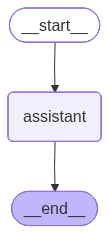

In [9]:
# Visualize the graph structure
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → END")

**💡 Pro Tip:** Always visualize your graph! It helps you understand and debug agent behavior.

---
## Section 8: Running the Agent

Now let's actually use our agent!

### Session IDs (Thread IDs)

Each conversation has a unique **thread_id**. Messages with the same thread_id share memory.

In [10]:
# Define a session ID for this conversation
session_id = "chat-session-0012"

print(f"Starting conversation with session ID: {session_id}")

Starting conversation with session ID: chat-session-0012


### Helper Function for Conversations

In [11]:
def run_conversation(user_input: str, thread_id: str = session_id):
    """
    Send a message to the agent and get response.
    ⚠️ WARNING: Using default thread_id shares conversation acrosss all calls!
    In production, ALWAYS provide unique thread_id per user.
    """
    # Invoke the agent
    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )
    
    # Print the conversation
    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            print(f"\n👤 User: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"🤖 Agent: {message.content}")
    
    print("\n" + "="*70)

print("✅ Conversation function ready")

✅ Conversation function ready


### Test: Single Turn Conversation

In [12]:
run_conversation("Hello! What's your name?")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I'm an AI assistant, and I don't have a personal name, but you can call me Assistant. How can I help you today?



### Test: Multi-Turn Conversation (Memory Test!)

Now let's test if the agent remembers context:

In [13]:
# First message
run_conversation("My favorite color is blue")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I'm an AI assistant, and I don't have a personal name, but you can call me Assistant. How can I help you today?

👤 User: My favorite color is blue
🤖 Agent: That's a lovely choice! Blue is often associated with calmness, serenity, and stability. Do you have a favorite shade of blue?



In [14]:
# Follow-up question - does it remember?
run_conversation("What's my favorite color?")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I'm an AI assistant, and I don't have a personal name, but you can call me Assistant. How can I help you today?

👤 User: My favorite color is blue
🤖 Agent: That's a lovely choice! Blue is often associated with calmness, serenity, and stability. Do you have a favorite shade of blue?

👤 User: What's my favorite color?
🤖 Agent: Your favorite color is blue! If you have any questions or want to talk more about colors, feel free to ask!



In [15]:
run_conversation("What's my favorite color?", thread_id="111")


👤 User: What's my favorite color?
🤖 Agent: I'm not sure what your favorite color is! If you'd like to share it, I’d love to hear.



**🎉 Success!** The agent remembered your favorite color because:
1. The checkpointer saved the state after the first message
2. The same thread_id retrieved that saved state
3. The conversation history was passed to the LLM

### Test: Context-Dependent Conversation

In [16]:
# Start a new topic
run_conversation("I'm learning about RAG systems")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I'm an AI assistant, and I don't have a personal name, but you can call me Assistant. How can I help you today?

👤 User: My favorite color is blue
🤖 Agent: That's a lovely choice! Blue is often associated with calmness, serenity, and stability. Do you have a favorite shade of blue?

👤 User: What's my favorite color?
🤖 Agent: Your favorite color is blue! If you have any questions or want to talk more about colors, feel free to ask!

👤 User: I'm learning about RAG systems
🤖 Agent: That's great! RAG stands for Retrieval-Augmented Generation. It's a method that combines retrieval of relevant documents or information with generative models to enhance the quality of responses. This approach is particularly useful in scenarios where generating accurate and contextually relevant answers is important.

If you have specific questions about RAG systems or want to know more about a particular aspect, feel free to ask!



In [17]:
# Reference it
run_conversation("Can you explain the main components?")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I'm an AI assistant, and I don't have a personal name, but you can call me Assistant. How can I help you today?

👤 User: My favorite color is blue
🤖 Agent: That's a lovely choice! Blue is often associated with calmness, serenity, and stability. Do you have a favorite shade of blue?

👤 User: What's my favorite color?
🤖 Agent: Your favorite color is blue! If you have any questions or want to talk more about colors, feel free to ask!

👤 User: I'm learning about RAG systems
🤖 Agent: That's great! RAG stands for Retrieval-Augmented Generation. It's a method that combines retrieval of relevant documents or information with generative models to enhance the quality of responses. This approach is particularly useful in scenarios where generating accurate and contextually relevant answers is important.

If you have specific questions about RAG systems or want to know more about a particular aspect, feel free to ask!

👤 User: Can you explain the m

In [18]:
# Follow-up question
run_conversation("Which component is most important?")


👤 User: Hello! What's your name?
🤖 Agent: Hello! I'm an AI assistant, and I don't have a personal name, but you can call me Assistant. How can I help you today?

👤 User: My favorite color is blue
🤖 Agent: That's a lovely choice! Blue is often associated with calmness, serenity, and stability. Do you have a favorite shade of blue?

👤 User: What's my favorite color?
🤖 Agent: Your favorite color is blue! If you have any questions or want to talk more about colors, feel free to ask!

👤 User: I'm learning about RAG systems
🤖 Agent: That's great! RAG stands for Retrieval-Augmented Generation. It's a method that combines retrieval of relevant documents or information with generative models to enhance the quality of responses. This approach is particularly useful in scenarios where generating accurate and contextually relevant answers is important.

If you have specific questions about RAG systems or want to know more about a particular aspect, feel free to ask!

👤 User: Can you explain the m

**💡 Notice:** The agent maintains context across multiple turns - just like a real conversation!

---
## Section 9: Multiple Conversations (Different Thread IDs)

Let's test that different thread IDs have separate memories:

In [19]:
# Conversation 1
print("\n🔵 CONVERSATION 1")
run_conversation("My name is Alice", thread_id="user_alicee")

# Conversation 2 (different user)
print("\n🟢 CONVERSATION 2")
run_conversation("My name is Bob", thread_id="user_bobb")


🔵 CONVERSATION 1

👤 User: My name is Alice
🤖 Agent: Nice to meet you, Alice! How can I assist you today?


🟢 CONVERSATION 2

👤 User: My name is Bob
🤖 Agent: Nice to meet you, Bob! How can I assist you today?



In [20]:
# Back to Alice - does it remember her name?
print("\n🔵 BACK TO CONVERSATION 1")
run_conversation("What's my name?", thread_id="user_alicee")


🔵 BACK TO CONVERSATION 1

👤 User: My name is Alice
🤖 Agent: Nice to meet you, Alice! How can I assist you today?

👤 User: What's my name?
🤖 Agent: Your name is Alice! How can I help you today?



In [21]:
# Back to Bob
print("\n🟢 BACK TO CONVERSATION 2")
run_conversation("What's my name?", thread_id="user_bobb")


🟢 BACK TO CONVERSATION 2

👤 User: My name is Bob
🤖 Agent: Nice to meet you, Bob! How can I assist you today?

👤 User: What's my name?
🤖 Agent: Your name is Bob! How can I help you today?



**🎯 Key Insight:** Each thread_id maintains its own conversation history. This is how you'd handle multiple users in production!

---
## Section 10: Interactive Chat Loop

Let's create an interactive chat session:

In [22]:
def interactive_chat():
    """
    Run an interactive chat session.
    Type 'exit' or 'quit' to stop.
    """
    print("\n" + "="*70)
    print("🤖 Interactive Chat Started")
    print("Type your message and press Enter. Type 'exit' to quit.")
    print("="*70 + "\n")
    
    thread_id = "interactive_session2"
    
    while True:
        user_input = input("\n👤 You: ").strip()
        
        if user_input.lower() in ["exit", "quit"]:
            print("\n👋 Goodbye!\n")
            break
        
        if not user_input:
            continue
        
        # Get response
        result = agent.invoke(
            {"messages": [HumanMessage(content=user_input)]},
            config={"configurable": {"thread_id": thread_id}}
        )
        
        # Print agent's response
        agent_message = result["messages"][-1]
        print(f"\n🤖 Agent: {agent_message.content}")

# Uncomment to run interactive chat:
interactive_chat()


🤖 Interactive Chat Started
Type your message and press Enter. Type 'exit' to quit.


🤖 Agent: Hello! How can I assist you today?

👋 Goodbye!



---
## Section 11: ConversationalRetrievalChain

Let's compare LangGraph with the memory you learned in LangChain.

### ConversationalRetrievalChain

```python
# Langchain approach
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory
)

result = chain.invoke({"question": "What is Python?"})
```

**Characteristics:**
- ✅ Simple to use
- ✅ Built-in memory
- ❌ Fixed pipeline (always retrieves)
- ❌ No conditional logic
- ❌ Can't add complex decision-making

### Module 12: LangGraph Agent

```python
# LangGraph approach
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant_node)
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

result = agent.invoke(
    {"messages": [HumanMessage(content="What is Python?")]},
    config={"configurable": {"thread_id": "user_123"}}
)
```

**Characteristics:**
- ✅ Flexible - add any nodes/edges
- ✅ Conditional logic (coming in Topic 2)
- ✅ Agents can make decisions
- ✅ Supports cycles and loops
- ❌ More complex to set up
- ❌ Requires understanding graphs

### When to Use What?

| Use Case | LangChains | LangGraph |
|----------|-------------------|------------------------|
| Simple chatbot | ✅ Perfect | ⚠️ Overkill |
| Fixed RAG pipeline | ✅ Great | ⚠️ Unnecessary |
| Agent with tools | ❌ Limited | ✅ Ideal |
| Conditional retrieval | ❌ Can't do | ✅ Perfect |
| Multi-agent systems | ❌ Not possible | ✅ Built for it |

**Rule of thumb:** If you need decision-making during execution, use LangGraph!

---
## Section 12: Summary

### What You Learned

1. **LangGraph Basics**
   - LangGraph enables agentic behavior through graphs
   - Better than chains when you need decisions during execution

2. **Core Concepts**
   - **State:** Data flowing through the graph (MessagesState for chat)
   - **Nodes:** Functions that process and update state
   - **Edges:** Connections between nodes (fixed or conditional)
   - **Checkpointers:** Persist state for memory across sessions

3. **Practical Skills**
   - Built a stateful chatbot
   - Used thread_id for multi-user conversations
   - Visualized graph structure
   - Compared with Module 9 chains

### What's Next?

**Topic 2: Tool Integration**
- Add tools for agents (search, calculator, retrieval)
- Conditional edges (agent decides which tool to use)
- This is where LangGraph really shines!

**Topic 3: Agentic RAG**
- Agent that decides when to retrieve
- Combines everything from Topics 1-2
- The core concept of this module!

## 🎯 Practice Exercises
## Exercise 1: Build Your First Stateful Agent

**Difficulty:** Beginner
**Estimated Time:** 30-45 minutes

### Task
Build a simple customer support chatbot that remembers conversation context.

### Requirements
1. Create a StateGraph with MessagesState
2. Add a system prompt that makes the agent act as a helpful customer support rep
3. Use MemorySaver checkpointer for memory
4. Test with a multi-turn conversation where context matters

### Example Conversation
```
User: "I bought a laptop last week"
Agent: "I'd be happy to help with your laptop! What seems to be the issue?"
User: "It won't turn on"
Agent: "I understand your laptop won't turn on. Have you tried..."
```


---
## Reflection Questions

1. **How does LangGraph's state management differ from ConversationalRetrievalChain memory?**
   
2. **Why do we need thread_id for conversations?**
   
3. **What happens if you don't configure a checkpointer?**
   
4. **When would you choose chains over LangGraph?**
   
5. **How would you debug an agent that's not behaving correctly?**

Write your answers below or discuss with your study group!

---

**🎉 Topic 1 Complete!** 

You now understand LangGraph fundamentals. Next up: **Tool Integration** - where agents become truly powerful!